In [1]:
#Credit: https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from sklearn.cross_validation import train_test_split
from collections import defaultdict
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
from sklearn.feature_extraction import text 
from sklearn.cross_validation import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS
import re
#import findspark
#findspark.init()
#import pyspark
#from pyspark.sql import SQLContext
import nltk
import pprint
#nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import ward, dendrogram
stopwords=text.ENGLISH_STOP_WORDS
#DATAFILEPATH='/Users/Dilip_MBP/Documents/CS109/PROJECT/project_cs109/data/'
DATAFILEPATH='/Users/qubyte/Documents/Harvard-DataScience/CS109/PROJECT/project_cs109/data/'
#DATAFILEPATH='C:/Users/balachandrd/Documents/Personal/CS-109/Project/project_cs109/data/'

In [2]:
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")
regex3=re.compile(r"\\\\")
stopwords=text.ENGLISH_STOP_WORDS

#Since we are looking for only nouns, we want to avoid parsing for most popular words such as 'bike' and 'bicycle'
CUSTOM_STOPWORDS_NOUN=['bike', 'bicycle']
CUSTOM_STOPWORDS=['']


In [3]:
bike_masterdf = pd.read_csv(DATAFILEPATH+'bike_details.csv',encoding='utf-8')
print "Number of samples in the database:", bike_masterdf.shape[0]
bike_masterdf.head(2)

Number of samples in the database: 59619


,Unnamed: 0,id,title,serial,manufacturer_name,frame_model,year,thumb,large_img,is_stock_img,stolen,stolen_location,date_stolen,registration_created_at,registration_updated_at,url,api_url,manufacturer_id,paint_description,name,frame_size,description,rear_tire_narrow,front_tire_narrow,type_of_cycle,test_bike,rear_wheel_size_iso_bsd,front_wheel_size_iso_bsd,handlebar_type_slug,frame_material_slug,front_gear_type_slug,rear_gear_type_slug,stolen_id,s_date_stolen,s_location,latitude,longitude,theft_description,locking_description,lock_defeat_description,police_report_number,police_report_department,s_rec_created_at,create_open311,sder_formatted_address,sder_street_number,sder_route,sder_postal_code,sder_neighborhood,sder_city,sder_county,sder_state,sder_country,date_stolen_epoch,registration_created_at_epoch,registration_updated_at_epoch,s_rec_created_at_epoch
0,0,50088,Schwinn Gateway,absent,Schwinn,Gateway,NaN,NaN,NaN,False,False,NaN,1970-01-01 00:00:00,2015-07-06 22:27:01,2015-11-03 05:36:54,https://bikeindex.org/bikes/50088,https://bikeindex.org/api/v1/bikes/50088,117,NaN,NaN,NaN,NaN,True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1436221621,1446529014,0
1,1,60140,2016 Specialized Diverge Elite DSW,WSBC601010269K,Specialized,Diverge Elite DSW,2016,NaN,NaN,False,False,NaN,1970-01-01 00:00:00,2015-10-08 19:18:50,2015-11-03 05:34:30,https://bikeindex.org/bikes/60140,https://bikeindex.org/api/v1/bikes/60140,307,NaN,NaN,52cm,NaN,True,NaN,Bike,False,NaN,NaN,NaN,aluminum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1444331930,1446528870,0


### Taking a peek

From the above excerpt of theft description, we can already see that some descriptions are almost too abrupt and to the point e.g. bike rack, thereby relaying very little information other than where the bike was prior to theft. Some  descriptions detail on how the bike was secured prior to theft and other descriptions talk about renumerations. There definitely is a lot of text cleaning that is required. 

In [4]:
# Remove nulls in theft description - only stolen bikes have theft description -> store in filtered dataframe
num_stolen = len(bike_masterdf.stolen[bike_masterdf.stolen == True])
print "Number of bikes reported as stolen: ", num_stolen
print "Proportion of bikes reported as stolen:  %.2f" % (float(num_stolen)/float(bike_masterdf.shape[0]))
desc_mask = bike_masterdf.theft_description.isnull()
bike_subdf1 = bike_masterdf[~desc_mask]
desc_mask2 = bike_subdf1.theft_description == ' '
bike_subdf = bike_subdf1[~desc_mask2]
print "Number of Stolen bikes with theft description:", bike_subdf.shape[0]

bike_subdf.to_csv(DATAFILEPATH+'stolen_bikes.csv',encoding='utf-8')
bike_subdf.head(2)

Number of bikes reported as stolen:  33182
Proportion of bikes reported as stolen:  0.56
Number of Stolen bikes with theft description: 28728


,Unnamed: 0,id,title,serial,manufacturer_name,frame_model,year,thumb,large_img,is_stock_img,stolen,stolen_location,date_stolen,registration_created_at,registration_updated_at,url,api_url,manufacturer_id,paint_description,name,frame_size,description,rear_tire_narrow,front_tire_narrow,type_of_cycle,test_bike,rear_wheel_size_iso_bsd,front_wheel_size_iso_bsd,handlebar_type_slug,frame_material_slug,front_gear_type_slug,rear_gear_type_slug,stolen_id,s_date_stolen,s_location,latitude,longitude,theft_description,locking_description,lock_defeat_description,police_report_number,police_report_department,s_rec_created_at,create_open311,sder_formatted_address,sder_street_number,sder_route,sder_postal_code,sder_neighborhood,sder_city,sder_county,sder_state,sder_country,date_stolen_epoch,registration_created_at_epoch,registration_updated_at_epoch,s_rec_created_at_epoch
3,3,11542,2013 Trek 4300,WTU124C5170G,Trek,4300,2013,NaN,NaN,False,True,"San Jose, CA, 95126",2013-06-10 06:00:00,2013-08-20 06:00:00,2015-11-03 05:11:14,https://bikeindex.org/bikes/11542,https://bikeindex.org/api/v1/bikes/11542,47,NaN,NaN,NaN,"Trek 4300, Mountain bicycle, disc brakes, blac...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,7889,1370844000,"San Jose, CA, 95126",37.329012,-121.916021,bike rack,NaN,NaN,T13006853,San Jose,2014-06-14 17:52:49,False,"1323 Martin Ave, San Jose, CA 95126, USA",1323,Martin Avenue,95126,Shasta-Hanchett Park,San Jose,Santa Clara County,California,United States,1370844000,1376978400,1446527474,1402768369
4,4,13359,2010 Schwinn Katana,absent,Schwinn,Katana,2010,https://files.bikeindex.org/uploads/Pu/4903/sm...,https://files.bikeindex.org/uploads/Pu/4903/la...,False,True,"Sandusky, OH, 44870",2010-07-10 06:00:00,2010-07-11 06:00:00,2015-11-03 05:17:53,https://bikeindex.org/bikes/13359,https://bikeindex.org/api/v1/bikes/13359,117,NaN,NaN,58cm,"The bike is a grey, blue, and black Schwinn Ka...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,9705,1278741600,"Sandusky, OH, 44870",41.440356,-82.768114,car bike rack Reward: $75,NaN,NaN,2010004433,Sandusky,2014-06-14 18:17:08,False,"4614 Venice Heights Blvd, Sandusky, OH 44870, USA",4614,Venice Heights Boulevard,44870,NaN,Sandusky,Erie County,Ohio,United States,1278741600,1278828000,1446527873,1402769828


In [5]:
#Peek at theft description

print (bike_subdf.theft_description[0:15])

3                                             bike rack
4                             car bike rack Reward: $75
5                      Backyard Reward: I have no money
6                              Open Garage Reward: $300
7     15\\" thick steel hand railing to which my bik...
8                              Powell Park Reward: $100
9                 PCC SE Campus at SE 82nd and Division
10                                         Reward: $150
11    A bike rack. Reward: A BIG HUG, MAYBE MONEY TO...
14                                         McDonald\\'s
15                                bike rack Reward: 200
16                                bike rack Reward: 200
17                              se 19th and se brooklyn
18    2131 NE 11th Ave Portland, OROut of my garage ...
19                         Outside of 120 NW Trinity Pl
Name: theft_description, dtype: object


Theft description with maximum word count: 558
Theft description with minimum word cunt:  1
Average word count of description: 10.61


/Users/qubyte/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


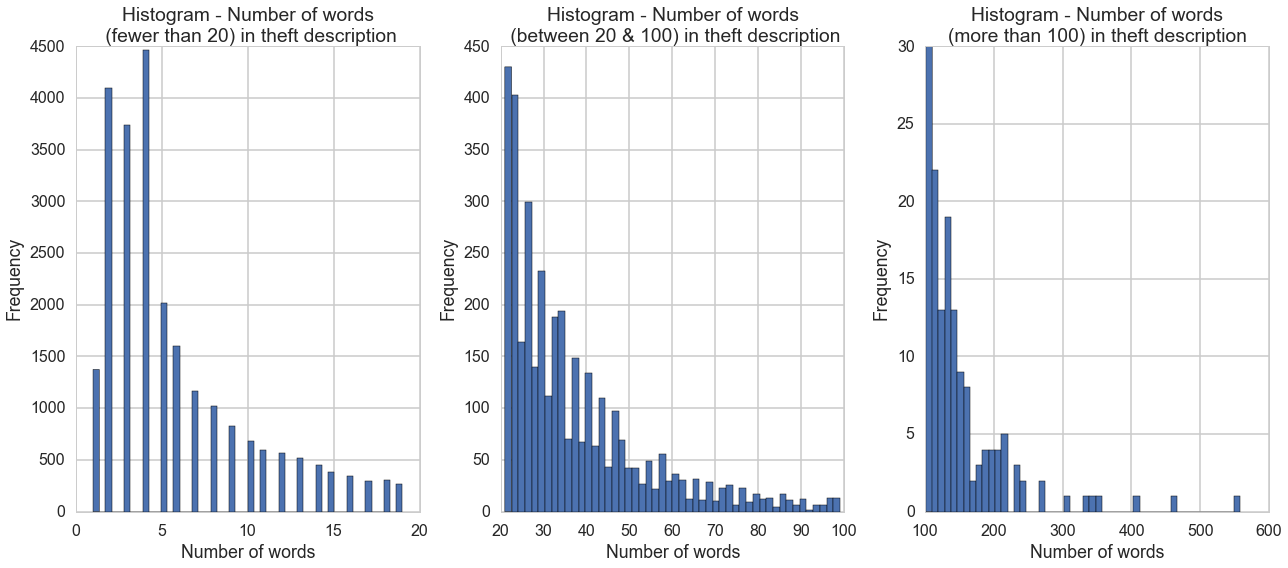

In [6]:
#Peek at the description data - Basic exploratory analysis

# Split each theft description to number of words to get an idea of how long the descriptions are
# exploratory
theft_desc_word_count = bike_subdf.theft_description.apply(lambda x: len(x.split()))


print "Theft description with maximum word count:", max(theft_desc_word_count)
print "Theft description with minimum word cunt: ", min(theft_desc_word_count)
print "Average word count of description: %.2f" % np.mean(theft_desc_word_count)
theft_desc_word_count_small = theft_desc_word_count[theft_desc_word_count < 20]
theft_desc_word_count_mid = theft_desc_word_count[(theft_desc_word_count > 20) & (theft_desc_word_count < 100)]
theft_desc_word_count_large = theft_desc_word_count[theft_desc_word_count > 100]
#theft_desc_word_count_small.tolist

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 8), tight_layout=True)
ax1.hist(theft_desc_word_count_small.tolist(), bins=50,histtype='bar' )
ax1.set_title('Histogram - Number of words \n (fewer than 20) in theft description')
ax1.set_xlabel('Number of words')
ax1.set_ylabel('Frequency')
ax2.hist(theft_desc_word_count_mid.tolist(), bins=50,histtype='bar' )
ax2.set_title('Histogram - Number of words \n (between 20 & 100) in theft description')
ax2.set_xlabel('Number of words')
ax2.set_ylabel('Frequency')
ax3.hist(theft_desc_word_count_large.tolist(), bins=50,histtype='bar' )
ax3.set_title('Histogram - Number of words \n(more than 100) in theft description')
ax3.set_xlabel('Number of words')
ax3.set_ylabel('Frequency')

### Theft description as a bunch of words

The sentences in theft description were split in to individual words to get an understanding of the amount of effort put by the bike owners in to describing the theft. The average number of words per description is about 10-11 where as there are exceptions with 558 as being the maximum and some with as very little as 1. 

The above histogram gives an idea of the text distribution. A large number of theft descriptions are fewer than 5 words, with 2 and 4 words per description being the most common. There is a substantial dip in the number theft descriptions with 20 to 100 words. The dip is seen once again past the 100 word mark. 

This goes to show that bike owners typically take less interest in detailing the theft while submitting information about theft. It also could be that those who chose to write fewer words possibly had less expensive bikes vs those who chose to write more than 100 words. Those who wrote detailed descriptions possibly had expensive bikes and wanted to give as much information as possible or are really thorough in their work.

In [7]:
# Create function to parse incoming text, tokenize and check for  ******* Nouns
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")
regex3=re.compile(r"\\\\")
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')

def gather_nouns(thetext, cust_words_list=[]):
    NEW_CUST_STOPWORDS_NOUN = CUSTOM_STOPWORDS_NOUN
    if (len (cust_words_list) > 0):
        
        for x in range(len(cust_words_list)):
            tempvar1 = cust_words_list
            NEW_CUST_STOPWORDS_NOUN.extend(tempvar1)
            
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    thetext=re.sub(regex3, ' ', thetext)
    thetext = thetext.lower()
    nouns=[]
    for sentence in parse(thetext, tokenize=True, lemmata = True, encoding = 'utf-8').split():
        for token in sentence:
            #print token
            if len(token[4]) >0:
                if token[1] in ['NN', 'NNS']:
                    if token[4] in NEW_CUST_STOPWORDS_NOUN or token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns.append(token[4])
    nouns2=[]

    for n in nouns:
        if len(n)!=0:
            nouns2.append(n)
        else:
            print "************** WE HAVE A PROBLEM **************"
    return ' '.join(nouns2)


def gather_nouns_and_adj(thetext, cust_words_list=[]):
    NEW_CUST_STOPWORDS = CUSTOM_STOPWORDS
    if (len (cust_words_list) > 0):

        for x in range(len(cust_words_list)):
            tempvar2 = cust_words_list
            NEW_CUST_STOPWORDS.extend(tempvar2)

        
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    thetext=re.sub(regex3, ' ', thetext)
    thetext = thetext.lower()
    tokens=[]
    for sentence in parse(thetext, tokenize=True, lemmata = True, encoding = 'utf-8').split():
        for token in sentence:
            #print token
            if len(token[4]) >0:
                if token[1] in ['NN','NNS','NNP','JJ','JJR','JJS' ]:
                    if token[4] in NEW_CUST_STOPWORDS or token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    
                    #print token[4]    
                    tokens.append(token[4])
    tokens2=[]

    for n in tokens:
        if len(n)!=0:
            tokens2.append(n)
            # Remove repeating bigrams (e.g bike bike)
            if (len(tokens2) !=1):
                if (tokens2[-1] == tokens2[-2]):
                    tokens2.pop()
            
            
                            
        else:
            print "************** WE HAVE A PROBLEM **************"
    return ' '.join(tokens2)

In [8]:
# Test parsing functions to understand if parsing will be fine
# Following sentence was constructed on the fly and does not belong to the BikeIndex data

atext = "The bikes were locked to a sign pole in my apartment by the corner of the superstore. The lock was a combination lock and i had \
tied chained my helmet to the bike. We have fairly good security in the block of apartments here. The bike was of make 'GT' with shimano \
gears and had a custom seat. The apartment's security office told me that i have no chance of retrieving the bike. My counsin' bike was \
stolen from their home's open garage overnight reward"

print gather_nouns(atext)
print "\n"
print gather_nouns(atext, ['reward'])
print "\n"
print gather_nouns_and_adj(atext)
print "\n"




sign pole apartment corner superstore lock combination lock helmet security block apartment make gt shimano gear custom seat apartment security office chance counsin home garage reward


sign pole apartment corner superstore lock combination lock helmet security block apartment make gt shimano gear custom seat apartment security office chance counsin home garage


bike sign pole apartment corner superstore lock combination lock helmet bike good security block apartment bike make gt shimano gear custom seat apartment security office chance bike counsin bike home open garage overnight reward




### Parse Nouns
Theft description data takes on a broad spectrum when it comes to context. Each owner posting theft description has their own style, can decide to be very specific or elaborate about the theft, could decide to focus on location of theft and describing the bike itself or could describe the circumstances yielding to the bike theft. Given that theft description can be approached from multiple angles, we shall start with gathering only the nouns from the description. The nouns will give an idea of 'what', 'where'. We are not really interested in the 'when'. If the data provided to us the 'Who' and 'Why', then the investigation could assume a different angle. 

In this discussion, we shall only focus on the 'what' and 'where'. Note that 'where' is already available in terms if 'location/city/coordinates' in the data. However, the 'where' in this case will be focussing on the type of property and its specifics.  We start with noun 'unigram' parsing. 


Note: As part of the stop words used for parsing the text, the words 'bike' and 'bicycle' were added to the stop words to avoid cluttering the parsed words with redundant information. This is only applicable if we are parsing for single words and NOT for bigrams or when looking for adjectives that may describe the theft.

In [9]:
# Parse Theft description for Nouns 
# Clean resulting data frame to remove null entries where no nouns were parsed from theft description
# Apply gather_nouns function, convert to dataframe and attach to original data frame for storing to file

noun_parsed = bike_subdf.theft_description.apply(gather_nouns)

noun_parsed = noun_parsed.to_frame()

noun_parsed.columns = ['theft_desc_nouns']

print "shape of data frame before appending parsed nouns: ", bike_subdf.shape
#Merge new dataframe with original
newdf = pd.concat([bike_subdf, noun_parsed], axis=1)

#Remove theft desc where cell is null/empty
null_mask_a = newdf.theft_desc_nouns == ''
bike_dfA = newdf[~null_mask_a].copy()

nullmask_a1 = bike_dfA.theft_desc_nouns.isnull()
bike_df_Nouns = bike_dfA[~nullmask_a1].copy()

print "shape of data frame after appending parsed nouns: ", bike_df_Nouns.shape
bike_df_Nouns['theft_desc_nouns'].head(10)

shape of data frame before appending parsed nouns:  (28728, 57)
shape of data frame after appending parsed nouns:  (25606, 58)


3                          rack
4                      car rack
5                backyard money
6                        garage
7     steel hand railing u-lock
8                   powell park
9               campus division
11               rack hug money
14                     mcdonald
15                         rack
Name: theft_desc_nouns, dtype: object

The next step is to convert the collection of text in to a matrix of token counts. In this study, we are interested in the frequency of a word/group of words appearing in theft descriptions. The more frequent a word/group of words appear(s), the more weight it should be given. Hence we will use the Term-Frequency (TF) approach and not the Term Frequency-Inverse Document Frequency as it would give less weight to words that are more frequent within and across the documents.

In [10]:
#Tokenize each theft description to return a list of nouns (ONLY)
# We will remove words whose word count is less than 2

vectorizer_nouns = CountVectorizer(min_df=2, stop_words='english')
nouns_sparse_matrix = vectorizer_nouns.fit_transform(bike_df_Nouns.theft_desc_nouns)

In [11]:
# From vectorizer, gather word-frequency data to look for highy frequency words
#Credit: http://stackoverflow.com/questions/16078015/list-the-words-in-a-vocabulary-according-to-occurrence-in-a-text-corpus-scikit

Nouns = vectorizer_nouns.get_feature_names()
Noun_Counts = np.asarray(nouns_sparse_matrix.sum(axis=0)).ravel()
Nouns_Freq = pd.DataFrame({'Nouns': Nouns, 'Count':Noun_Counts})
Sorted_Nouns_Freq = Nouns_Freq.sort(columns='Count', ascending=False)
Sorted_Nouns_Freq.to_csv(DATAFILEPATH+'Nouns_frequency.csv',encoding='utf-8')

### Nouns

Prior to doing any more analysis, we need to understand the frequency of the nouns in the descriptions. Given that the nouns will be descibing the 'what' and 'where' of the theft, we can expect a select set of words to be highly frequent among theft descriptions. Some of these words may make sense and other may not. At the same time, there will be a lot of words that may not be relevant to point of this investigation ('where').  As there can only be a handful of popular locations/points from which a bicycle can be stolen, we can preset this number temporarily to less than 100 and explore the data. Following graph, shows the top 90 words in the dataset.

In [12]:
# Plot bar graph of Frequency of top 200 words that were vectorized 
#
def plot_freq_chart(nrows, ncols, df_in, title_in, figw=16, figh=16) :
    x_label = df_in.columns[1]
    y_label = df_in.columns[0]
    plt_rows = np.arange(nrows)
    plt_cols = np.arange(ncols)
    f1, ax1 = plt.subplots(figsize=(figw,figh), nrows=nrows, ncols=ncols)
    f1.set_tight_layout(True)
    x = 0
    #sns.barplot(x='Nouns',y='Count',data= sorted_w_freq_df[0:10])
    for row in plt_rows:
        for col in plt_cols:
            a = sns.barplot(x=x_label,y=y_label,data=df_in[x:x+10], ax=ax1[row][col])
            #print row,col
            a.set_xticklabels(df_in[x_label][x:x+10].tolist(), rotation='vertical')
            a.set_ylabel('Word Frequency')
            a.set_title(title_in)
            x+=10
        x+=10

nrows=3
ncols=3



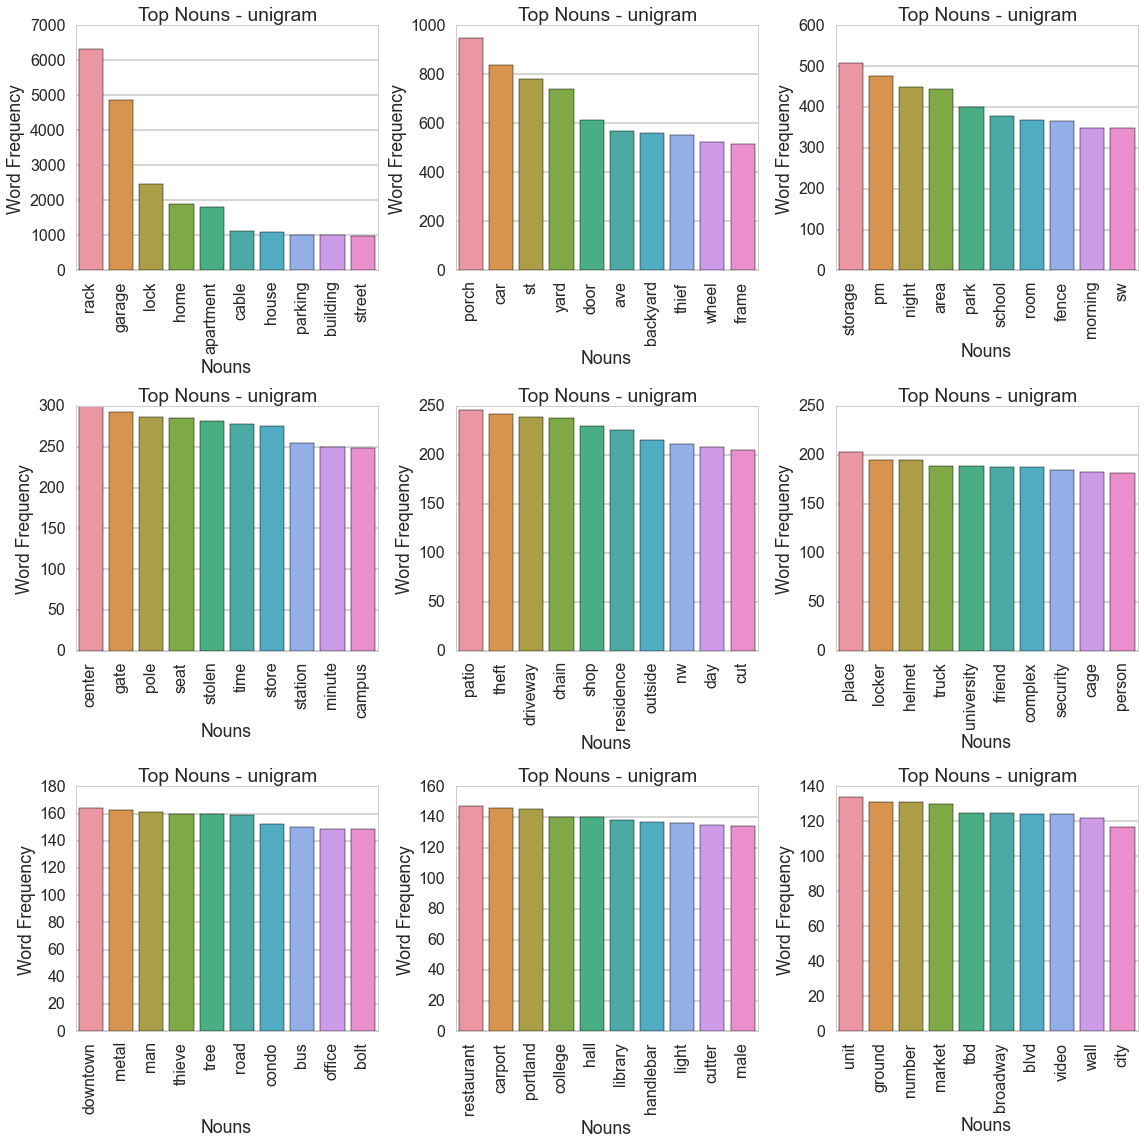

In [13]:
plot_freq_chart(3,3,Sorted_Nouns_Freq, "Top Nouns - unigram")

### Analysis of Nouns Word count

It is very surprising to note that the word 'reward' is the most frequently used word in the descriptions. Shows that a lot of bike owners are willing to give a reward if a bike is found. However, given the high frequency of the word ('reward') and the fact that we are looking for term frequency within each document (theft description), it is important to remove the word, reward, from the descriptions to allow for other words to surface. 

Looking at the other words in list, there is a lot of information available on exactly where the bike was stolen from. The above chart indicates that we may be missing part story if only focussing on the nouns. Here are few examples to illustrate the point:

a) word: rack
The word rack alone is unable to convey much information as the bicycle could have been on a rack in the garage, on the street, in a building etc.  

b) word: condo
Simply parsing the nouns for unigram definitely yields in disecting words such as condo apartment, resulting in two separate words; condo and apartment.

c) word: friend
The word friend by itself does not provide any information about the 'where' or 'what' that we are interested in. 

d) word: pole
The word pole is mostly associated with another noun and we lose the context of the description by looking for unigrams alone

The above exploration of the nouns word count indicates that looking at unigrams alone may/may not be helpful in identifying the 'what' that we are interested in.  To help us understand the descriptions better, we will proceed with parsing for bi-grams along with 'adjectives' in order to provide more meaning to words such as 'bolt', 'chain', 'room', 'fence' etc.


In [14]:
#Recalculate dataframe and nouns vector after excluding above identified stop words: 'reward'

new_noun_parsed = bike_subdf.theft_description.apply(gather_nouns,cust_words_list=['reward'])

new_noun_parsed = new_noun_parsed.to_frame()

new_noun_parsed.columns = ['theft_desc_nouns']

print "shape of data frame before appending parsed nouns: ", bike_subdf.shape
#Merge new dataframe with original
newdf_B = pd.concat([bike_subdf, new_noun_parsed], axis=1)

#Remove theft desc where cell is null/empty
null_mask_b = newdf_B.theft_desc_nouns == ''
bike_dfB = newdf_B[~null_mask_b].copy()

nullmask_b1 = bike_dfB.theft_desc_nouns.isnull()
bike_df_Nouns_final = bike_dfB[~nullmask_b1].copy()


vectorizer_nouns_final = CountVectorizer(min_df=2, stop_words='english')
nouns_sparse_matrix_final = vectorizer_nouns_final.fit_transform(bike_df_Nouns_final.theft_desc_nouns)



shape of data frame before appending parsed nouns:  (28728, 57)


In [15]:
bike_df_Nouns_final.to_csv(DATAFILEPATH+'bikes_trim_nouns.csv',encoding='utf-8' )

In [16]:
#Vectorize and gather word count upon removing 'reward'
rrr_Nouns = vectorizer_nouns_final.get_feature_names()
rrr_Noun_Counts = np.asarray(nouns_sparse_matrix_final.sum(axis=0)).ravel()

rrr_Nouns_Freq = pd.DataFrame({'Nouns': rrr_Nouns, 'Count':rrr_Noun_Counts})
rrr_Sorted_Nouns_Freq = rrr_Nouns_Freq.sort(columns='Count', ascending=False)


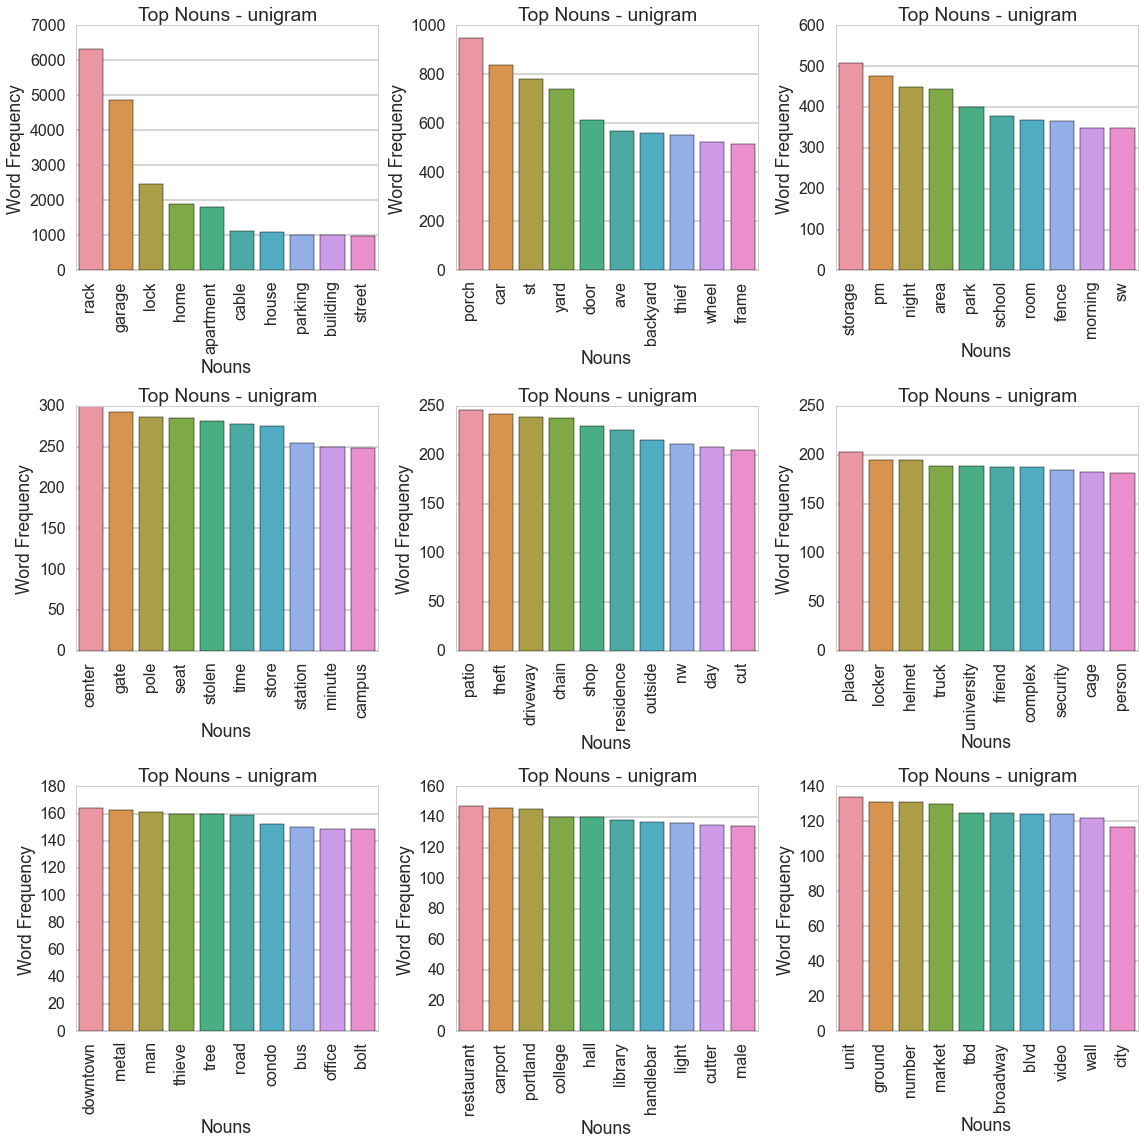

In [17]:
#Plot chart of word counts 
plot_freq_chart(3,3,rrr_Sorted_Nouns_Freq, "Top Nouns - unigram")

In [18]:
##############################################################################################
#Approaching parsing text as bi-grams: Bigrams would include both adjective and noun together

#Based on decision with nouns, we will remove 'reward' from 1+ n grams
noun_adj_parsed = bike_subdf.theft_description.apply(gather_nouns_and_adj,cust_words_list=['reward'] )
noun_adj_parsed = noun_adj_parsed.to_frame()
noun_adj_parsed.columns = ['theft_desc_nouns_adj']

#Merge new dataframe with original
bike_df_temp = bike_subdf.copy()
print "bike data frame shape before appending bigrams: ", bike_df_temp.shape

newdf1 = pd.concat([bike_df_temp, noun_adj_parsed], axis=1)

#Remove theft desc where cell is null/empty
null_mask_b = newdf1.theft_desc_nouns_adj == ''
bike_df_B = newdf1[~null_mask_b]

nullmask_b1 = bike_df_B.theft_desc_nouns_adj.isnull()
bike_df_Nouns_Adj = bike_df_B[~nullmask_b1]

print "bike data frame shape after appending bigrams: ", bike_df_Nouns_Adj.shape
bike_df_Nouns_Adj.head(2)



bike data frame shape before appending bigrams:  (28728, 57)
bike data frame shape after appending bigrams:  (26127, 58)


,Unnamed: 0,id,title,serial,manufacturer_name,frame_model,year,thumb,large_img,is_stock_img,stolen,stolen_location,date_stolen,registration_created_at,registration_updated_at,url,api_url,manufacturer_id,paint_description,name,frame_size,description,rear_tire_narrow,front_tire_narrow,type_of_cycle,test_bike,rear_wheel_size_iso_bsd,front_wheel_size_iso_bsd,handlebar_type_slug,frame_material_slug,front_gear_type_slug,rear_gear_type_slug,stolen_id,s_date_stolen,s_location,latitude,longitude,theft_description,locking_description,lock_defeat_description,police_report_number,police_report_department,s_rec_created_at,create_open311,sder_formatted_address,sder_street_number,sder_route,sder_postal_code,sder_neighborhood,sder_city,sder_county,sder_state,sder_country,date_stolen_epoch,registration_created_at_epoch,registration_updated_at_epoch,s_rec_created_at_epoch,theft_desc_nouns_adj
3,3,11542,2013 Trek 4300,WTU124C5170G,Trek,4300,2013,NaN,NaN,False,True,"San Jose, CA, 95126",2013-06-10 06:00:00,2013-08-20 06:00:00,2015-11-03 05:11:14,https://bikeindex.org/bikes/11542,https://bikeindex.org/api/v1/bikes/11542,47,NaN,NaN,NaN,"Trek 4300, Mountain bicycle, disc brakes, blac...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,7889,1370844000,"San Jose, CA, 95126",37.329012,-121.916021,bike rack,NaN,NaN,T13006853,San Jose,2014-06-14 17:52:49,False,"1323 Martin Ave, San Jose, CA 95126, USA",1323,Martin Avenue,95126,Shasta-Hanchett Park,San Jose,Santa Clara County,California,United States,1370844000,1376978400,1446527474,1402768369,bike rack
4,4,13359,2010 Schwinn Katana,absent,Schwinn,Katana,2010,https://files.bikeindex.org/uploads/Pu/4903/sm...,https://files.bikeindex.org/uploads/Pu/4903/la...,False,True,"Sandusky, OH, 44870",2010-07-10 06:00:00,2010-07-11 06:00:00,2015-11-03 05:17:53,https://bikeindex.org/bikes/13359,https://bikeindex.org/api/v1/bikes/13359,117,NaN,NaN,58cm,"The bike is a grey, blue, and black Schwinn Ka...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,9705,1278741600,"Sandusky, OH, 44870",41.440356,-82.768114,car bike rack Reward: $75,NaN,NaN,2010004433,Sandusky,2014-06-14 18:17:08,False,"4614 Venice Heights Blvd, Sandusky, OH 44870, USA",4614,Venice Heights Boulevard,44870,NaN,Sandusky,Erie County,Ohio,United States,1278741600,1278828000,1446527873,1402769828,car bike rack


In [19]:
bike_df_Nouns_Adj.to_csv(DATAFILEPATH+'bikes_trim_nouns_adj.csv',encoding='utf-8' )



A preliminary peek in to the dataframe created from parsing for adjectives and nouns already seem to be providing more detail. e.g. 'open garage' which we did not earlier when parsing for nouns only. 

In [20]:
#Vectorizer for bigrams on both Nouns and Adjectives
vectorizer_nouns_adj = CountVectorizer(min_df=2, ngram_range=(2,2), stop_words='english')
nouns_adj_sparse_matrix = vectorizer_nouns_adj.fit_transform(bike_df_Nouns_Adj.theft_desc_nouns_adj) 

Nouns_Adj = vectorizer_nouns_adj.get_feature_names()
Nouns_Adj_Counts = np.asarray(nouns_adj_sparse_matrix.sum(axis=0)).ravel()
Nouns_Adj_Freq = pd.DataFrame({'Nouns_Adjectives': Nouns_Adj, 'Count':Nouns_Adj_Counts})
Sorted_Nouns_Adj_Freq = Nouns_Adj_Freq.sort(columns='Count', ascending=False)
Sorted_Nouns_Adj_Freq.to_csv(DATAFILEPATH+'Nouns_Adj_frequency.csv',encoding='utf-8')

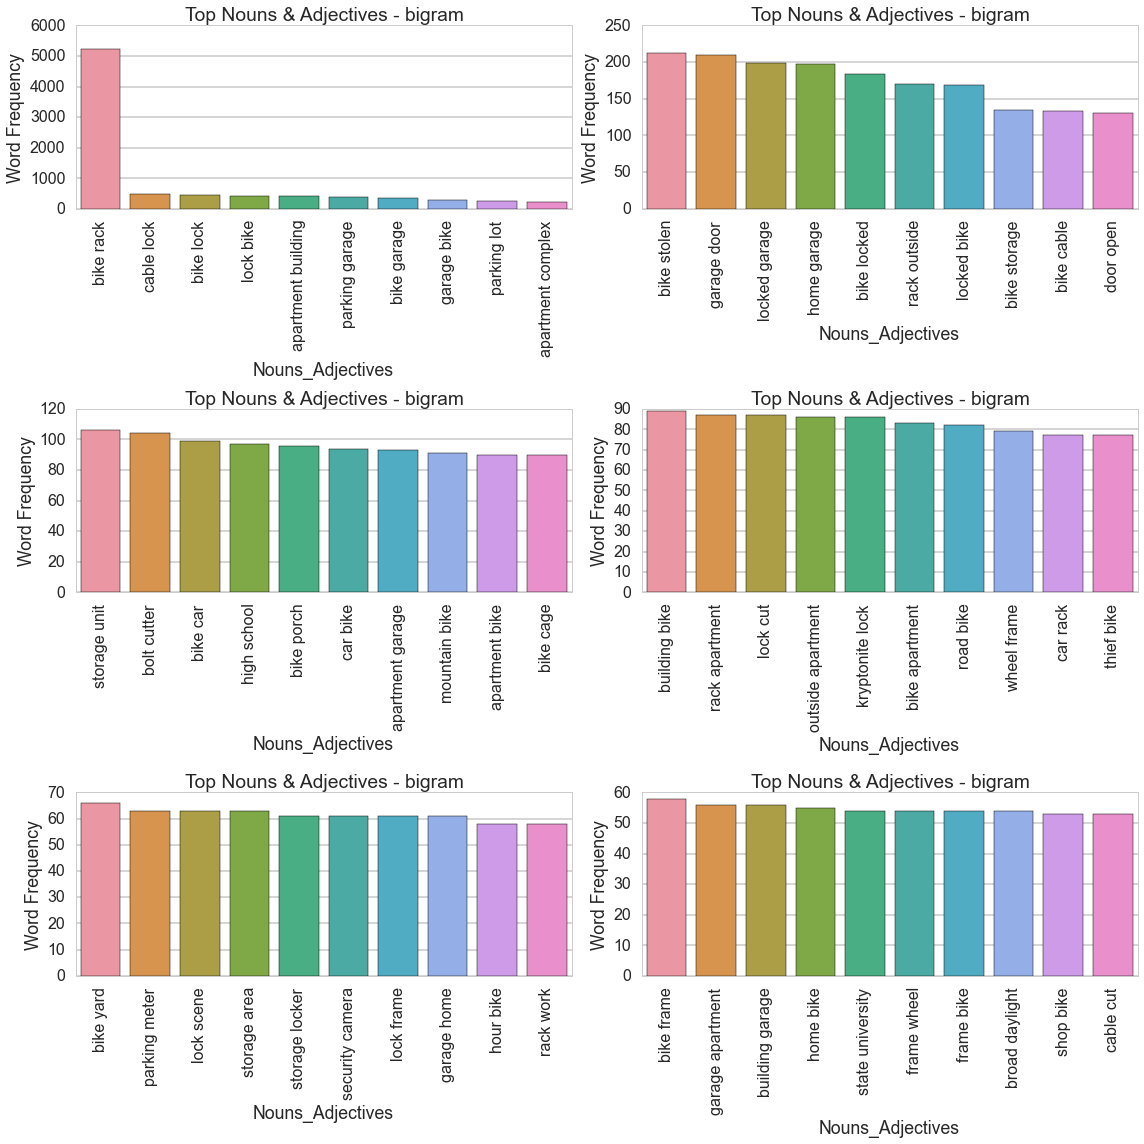

In [21]:
plot_freq_chart(3,2,Sorted_Nouns_Adj_Freq, "Top Nouns & Adjectives - bigram")

### Bigram analysis

The above bigram charts are far more descriptive in aptly identifying some of the key elements of each of the descriptions. As can be noted, some of the bigrams are still vague e.g. 'bike rack' (which also is the most frquently appearing pair of words) or 'cable bike' or 'bike car'. It is definitely likely that a single description of theft had more than 1 combination of the bigrams identified above. e.g. a theft description could have had both these bigrams ['door open' & 'parking garage'] or ['bike stolen' & 'outside apartment']. 

Word pairs such as'rack reward' , 'garage reward' and 'home reward' are unable to provide adequate meaning as we are limiting the parsing to two words.

This yeilds to an interesting question. So how many n-grams would be perfect? This all depends on what exactly are we looking at. The main focus of the theft description analysis is to identify specifics tied to the location from where a bike was stolen. We shall further our analysis with a tri-gram and gauge as to which of the three approaches to use (unigram, bigram or trigram).

In [22]:
#Vectorizer for trigrams on Nouns and Adjectives
vectorizer_nouns_adj_trigram = CountVectorizer(min_df=2, ngram_range=(3,3), stop_words='english')
nouns_adj_trigram_sparse_matrix = vectorizer_nouns_adj_trigram.fit_transform(bike_df_Nouns_Adj.theft_desc_nouns_adj) 

Nouns_Adj_trigram = vectorizer_nouns_adj_trigram.get_feature_names()
Nouns_Adj_trigram_Counts = np.asarray(nouns_adj_trigram_sparse_matrix.sum(axis=0)).ravel()
Nouns_Adj_trigram_Freq = pd.DataFrame({'Nouns_Adjectives_TRIGRAM': Nouns_Adj_trigram, 'Count':Nouns_Adj_trigram_Counts})
Sorted_Nouns_Adj_trigram_Freq = Nouns_Adj_trigram_Freq.sort(columns='Count', ascending=False)
Sorted_Nouns_Adj_trigram_Freq.to_csv(DATAFILEPATH+'Nouns_Adj_Trigram_frequency.csv',encoding='utf-8')

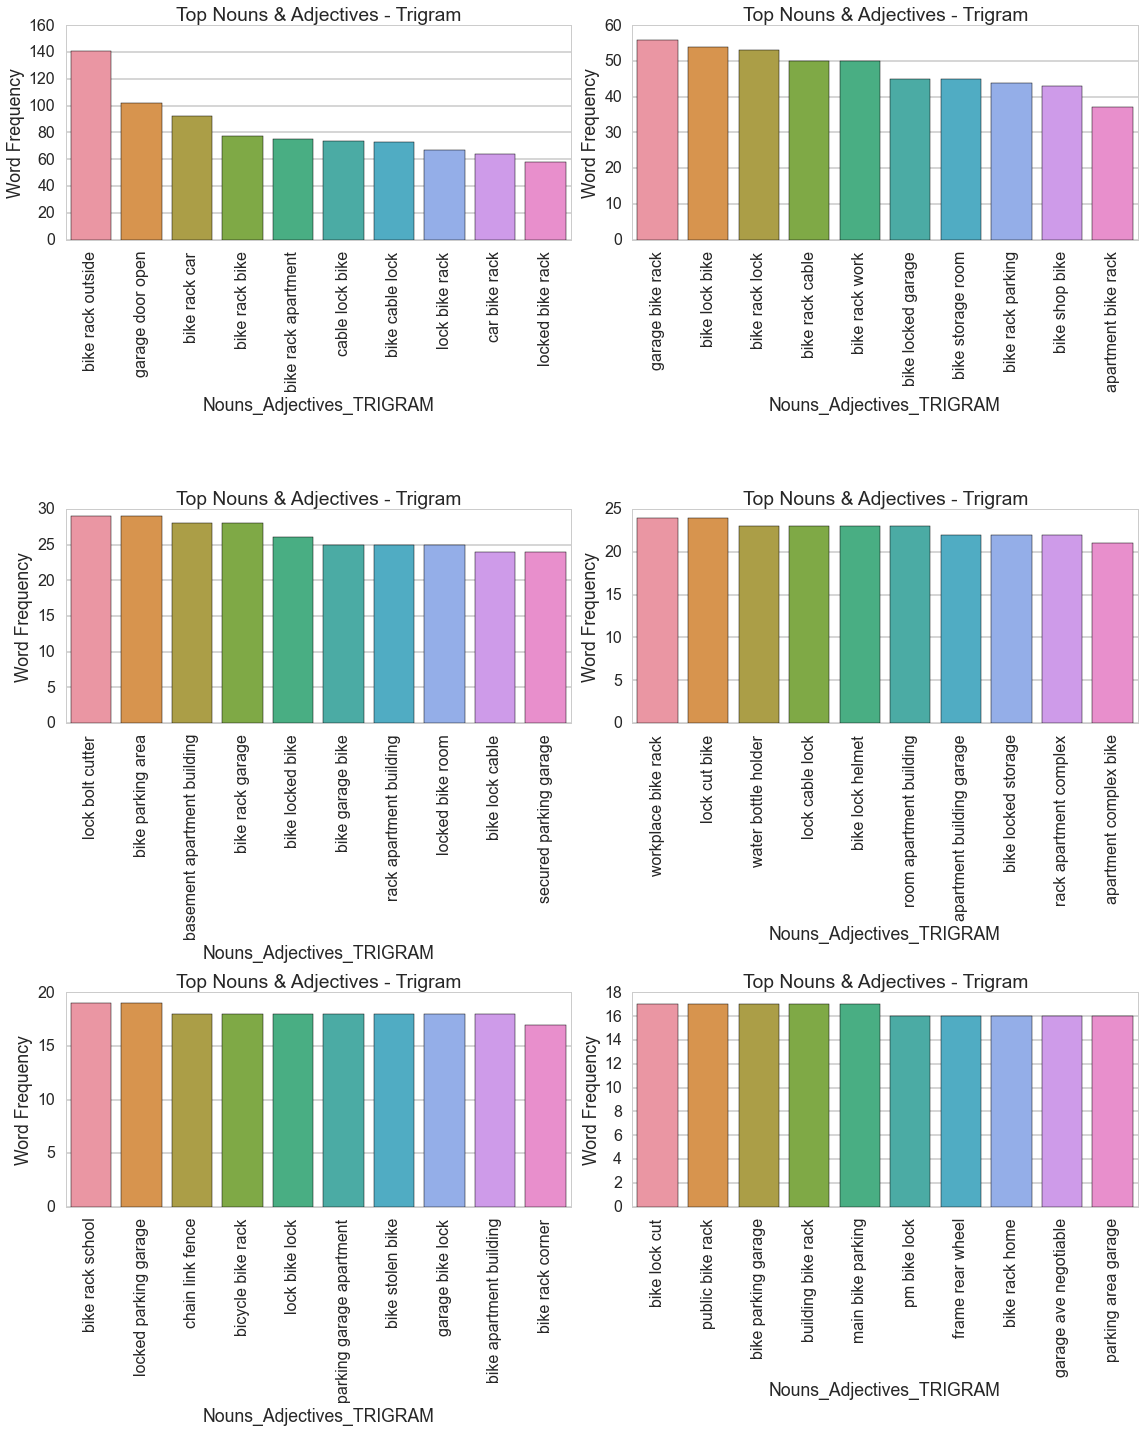

In [23]:
plot_freq_chart(3,2,Sorted_Nouns_Adj_trigram_Freq, "Top Nouns & Adjectives - Trigram",figw=16, figh=20)

### Trigram Analysis

It appears that trigram are conveying lots more information about the 'where' that we are interested in. At this point, we should keep in mind that the vast majority of the descriptions had fewer than 5 words. There were innumerous 2 word descriptions (~4200) but as we have already established, bigrams are not performing as well as the trigrams. Secondly, we can also reason that some of the 2 word descriptions could plausibly not all that explanatory and very well could be discarded for our analysis. 

We will now use the trigrams to continue with our analysis.

### Digging Deeper

At this point, we need to understand if and how these numerous features (5660) in the multidimensional space group together to form clusters that can help us derive a meaningful interpretation from theft description. We can guess the number of clusters (similar descriptions based on their features) and use that as a starting point. However, a random guess is as good as making none. To make an informed decision aboue the number of clusters, we can resort to randomly sampling a subset of the dataset and visualizing the text in 2 dimensions. A 2-dimensional visual of the theft descriptions would indicate any apparent clusters and act as a starting point.

To visualize the multi-dimensional vector space of the corpus, we resorted to MDS  (Multi Dimensional Scaling). The following section details on how MDS  was applied to 10% random sample from the Nouns only and Nouns&Adjectives corpus. The nouns were used to visualize the unigrams and the 'Nouns&Adjectives' were used to visualize the trigrams.



#### Cosine similarity

The cosine measure similarity is another similarity metric that depends on envisioning user descriptions as points in space. Each theft description from the users can be envisioned as a point in n-dimensional space. The cosine similarity calculates the angle between any of the two vectors in the n-dimensional space. Hence, for vectors that are close to each other/along the same direction ((similar theft descriptions), the difference in angle between them will be very small and vice versa.  


In [24]:
#Define function to obtain MDS coordinates of text data
#Credit https://de.dariah.eu/tatom/working_with_text.html

def get_mds(df_in, sample_size, nouns_only=True, ngram=1,num_jobs=1):
    dftouse = df_in.copy()
    itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=sample_size)
    #print len(itrain)
    mask=np.ones(dftouse.shape[0], dtype='int')
    mask[itrain]=1
    mask[itest]=0
    mask = (mask==1)
    #print mask.shape, mask.sum()
    if (nouns_only):
        print "MDS on Nouns only"
        rand_sample_text = dftouse['theft_desc_nouns'][mask]

    else:
        print "MDS on Nouns & Adjectives only"
        rand_sample_text = dftouse['theft_desc_nouns_adj'][mask]
        
    print rand_sample_text.shape
    #Remove null entries from parsed text
    nullmask_A = rand_sample_text.isnull()
    rand_sample_text = rand_sample_text[~nullmask_A].copy()

    #print len(rand_sample_text)
    vectorizer_rand_sample = CountVectorizer(min_df=2,ngram_range=(ngram,ngram),stop_words='english') #  
    rand_sample_sparse_matrix = vectorizer_rand_sample.fit_transform(rand_sample_text) 
    #rand_sample_feature_names = vectorizer_rand_sample.get_feature_names()
    #rand_sample_theft_desc = dftouse['theft_description'][mask].tolist()
    #rand_sample_nouns_adj = dftouse['theft_desc_nouns_adj'][mask].tolist()
    
    #rand_sample_full_matrix = rand_sample_sparse_matrix.toarray()
    distance_euc = euclidean_distances(rand_sample_sparse_matrix)
    
    distance_cos = cosine_similarity(rand_sample_sparse_matrix)
    
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1, n_jobs=num_jobs)
    pos_euc = mds.fit_transform(distance_euc)
    pos_cos = mds.fit_transform(distance_cos)
    
    return pos_euc, pos_cos




In [25]:

def mds_scatterplot(pos_euc, pos_cos, sample_size, fig_text):
    xs_euc, ys_euc = pos_euc[:, 0], pos_euc[:, 1]
    xs_cos, ys_cos = pos_cos[:, 0], pos_cos[:, 1]

    fig6, (ax6,ax7) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8), tight_layout=True)
    s_size = float(sample_size)*100
    fig_title = 'MDS scatter plots - Representing,', s_size, '% random sample of dataset'+fig_text
    fig6.suptitle(fig_title, fontsize=20)
    ax6.set_title('\n\nEuclidean distance')
    for x, y in zip(xs_euc, ys_euc):
        ax6.scatter(x, y, marker='o',alpha=0.5)

    ax7.set_title('\n\nCosine distance')
    for x, y in zip(xs_cos, ys_cos):
        ax7.scatter(x, y, marker='o',alpha=0.5)

In [26]:
#Define sample size to be used for MDS plot
sample_size_for_mds = 0.2

In [27]:
# Get MDS for trigrams on xx% subset of data (random sampling)
Nouns_Adj_sample_size=sample_size_for_mds
euc_3gram, cos_3gram = get_mds(bike_df_Nouns_Adj,sample_size=Nouns_Adj_sample_size, nouns_only=False, ngram=3)

MDS on Nouns & Adjectives only
(5225,)


In [28]:
# Get MDS for Unigrams on xx% subset of data (random sampling)
Nouns_sample_size=sample_size_for_mds
euc_1gram, cos_1gram = get_mds(bike_df_Nouns_final,sample_size=Nouns_sample_size, nouns_only=True, ngram=1)

MDS on Nouns only
(5121,)


/Users/qubyte/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


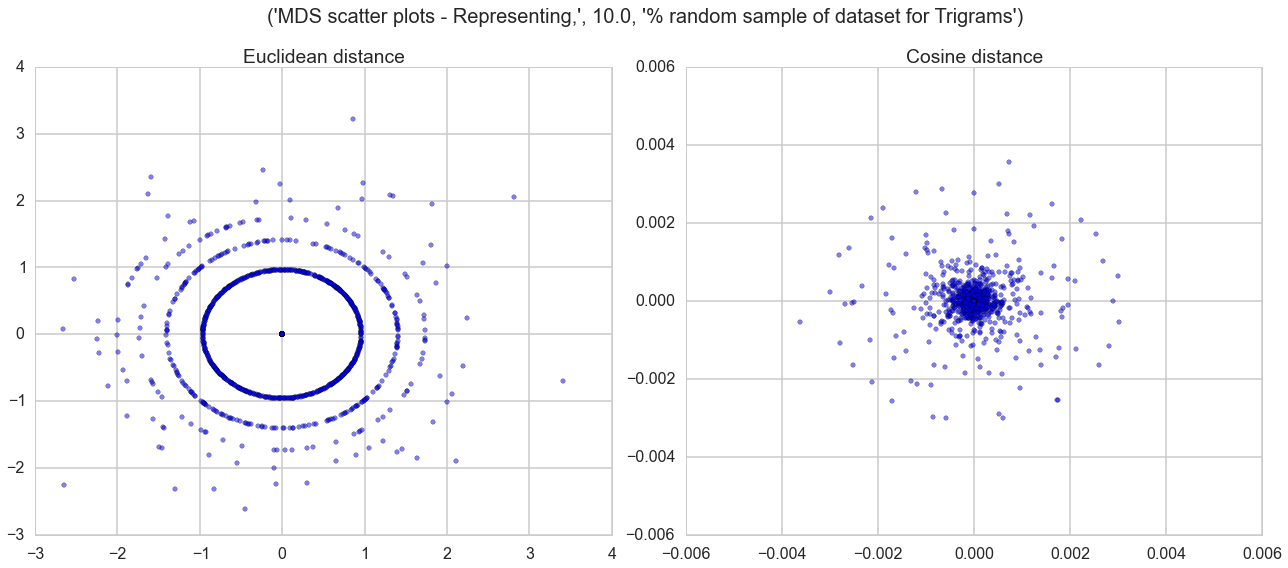

In [29]:
#MDS Scatter plot for trigrams (nouns and adjectives)
mds_scatterplot(euc_3gram, cos_3gram, 0.1, ' for Trigrams')

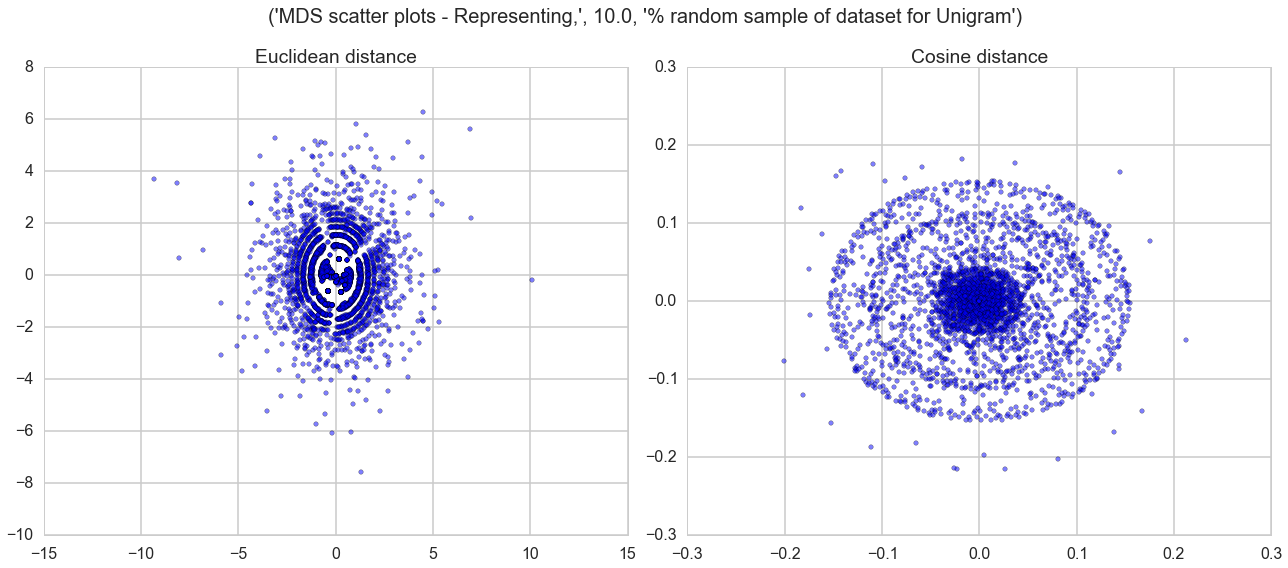

In [30]:
#MDS scatter plot for unigrams (nouns only)
mds_scatterplot(euc_1gram, cos_1gram, 0.1, ' for Unigram')

### # In practice Spectral Clustering is very useful when the structure of the individual clusters is highly non-convex or more generally when a measure of the center and spread of the cluster is not a suitable description of the complete cluster. For instance when clusters are nested circles on the 2D plan.

When calling fit, an affinity matrix is constructed using either kernel function such the Gaussian (aka RBF) kernel of the euclidean distanced d(X, X):

From: http://scikit-learn.org/stable/modules/clustering.html
Note that if the values of your similarity matrix are not well distributed, e.g. with negative values or with a distance matrix rather than a similarity, the spectral problem will be singular and the problem not solvable. In which case it is advised to apply a transformation to the entries of the matrix. 

Hence we will be using cosine similarity

# Spectral Clustering to identify labels belonging to clusters on TRIGRAMS
# Sampling 10 % of the samples.


####Assign the correct dataframe to dftouse 
spec_df = bike_df_Nouns_Adj.copy()

s_itrain, s_itest = train_test_split(xrange(spec_df.shape[0]), train_size=0.10)
#print len(itrain)
s_mask=np.ones(spec_df.shape[0], dtype='int')
s_mask[s_itrain]=1
s_mask[s_itest]=0
s_mask = (s_mask==1)
#print mask.shape, mask.sum()

s_rand_sample_text = spec_df['theft_desc_nouns_adj'][s_mask]
s_nullmask_A = s_rand_sample_text.isnull()
s_rand_sample_text = s_rand_sample_text[~s_nullmask_A].copy()

#print len(rand_sample_text)
s_vectorizer_rand_sample = CountVectorizer(min_df=2,ngram_range=(3,3),stop_words='english') #  
s_rand_sample_sparse_matrix = s_vectorizer_rand_sample.fit_transform(s_rand_sample_text) 
#rand_sample_feature_names = vectorizer_rand_sample.get_feature_names()
#rand_sample_theft_desc = dftouse['theft_description'][mask].tolist()
#rand_sample_nouns_adj = dftouse['theft_desc_nouns_adj'][mask].tolist()

# Compute Distances
#rand_sample_full_matrix = rand_sample_sparse_matrix.toarray()
#s_distance_euc = euclidean_distances(s_rand_sample_sparse_matrix)
s_distance_cos = cosine_similarity(s_rand_sample_sparse_matrix)


#TEMP to del

print len(s_rand_sample_text)
print s_distance_cos
#print distance_cos

num_clusters = np.arange(3,4)
spectral_model={}
spectral_labels={}
for i in num_clusters:
    %time spectral_model[i] = SpectralClustering(n_clusters=i,affinity="precomputed",random_state=1,assign_labels='discretize',gamma=1.0)
    
    #pass precomputer eucledian distance matrix to fit to spectral model
    %time spectral_labels[i] = spectral_model[i].fit(s_distance_cos)




# Spectral Clustering to identify labels belonging to clusters on Unigrams
# Sampling 11 % of the samples.


####Assign the correct dataframe to dftouse 
spec_df_n = bike_df_Nouns_final.copy()

s_itrain_n, s_itest_n = train_test_split(xrange(spec_df_n.shape[0]), train_size=0.11)
#print len(itrain)
s_mask_n=np.ones(spec_df_n.shape[0], dtype='int')
s_mask_n[s_itrain_n]=1
s_mask_n[s_itest_n]=0
s_mask_n = (s_mask_n==1)
#print mask.shape, mask.sum()

s_rand_sample_text_n = spec_df_n['theft_desc_nouns'][s_mask_n]
s_nullmask_A_n = s_rand_sample_text_n.isnull()
s_rand_sample_text_n = s_rand_sample_text_n[~s_nullmask_A_n].copy()


s_vectorizer_rand_sample_n = CountVectorizer(min_df=2,stop_words='english') #  
s_rand_sample_sparse_matrix_n = s_vectorizer_rand_sample_n.fit_transform(s_rand_sample_text_n) 

# Compute Distances
#rand_sample_full_matrix = rand_sample_sparse_matrix.toarray()
#s_distance_euc = euclidean_distances(s_rand_sample_sparse_matrix)
s_distance_cos_n = cosine_similarity(s_rand_sample_sparse_matrix_n)


#TEMP to del

print len(s_rand_sample_text_n)
print s_distance_cos_n
#print distance_cos

num_clusters_n = np.arange(5,7)
spectral_model_n={}
spectral_labels_n={}
for i in num_clusters_n:
    %time spectral_model_n[i] = SpectralClustering(n_clusters=i,affinity="precomputed",random_state=1,assign_labels='discretize',gamma=1.0)
    
    #pass precomputer eucledian distance matrix to fit to spectral model
    %time spectral_labels_n[i] = spectral_model_n[i].fit(s_distance_cos_n)





In [59]:
# Function to write clusters dervied from spectral clustering to file
def clusters_to_file(dfin, model_labels, min_clust, max_clust, file_name):
    num_clust_n = np.arange(min_clust,max_clust+1)
    dftemp = dfin.copy()
    for i in num_clust_n:
        clust = pd.Series(model_labels[i].labels_)
        clust_name='Noun_Clusters_'+str(i)
        dftemp[clust_name]=clust.values
    dftemp.to_csv(DATAFILEPATH+file_name, encoding='utf-8')
    return dftemp




#### Spectral clustering on Trigrams (Nouns and Adjectives)

#Run spectral clustering for trigrams on entire data set
#Create copy of dataframe (to retain dta intergrity of original)
spec_df1 = bike_df_Nouns_Adj.copy()
spec_nouns_adj_text = spec_df1['theft_desc_nouns_adj']

#Remove null values
spec_nullmask1 = spec_nouns_adj_text.isnull()
spec_full_text = spec_nouns_adj_text[~spec_nullmask1].copy()
print "Number of samples in dataset:", len(spec_full_text)

#create new trimmed dataframe
spec_full_df = spec_df1[~spec_nullmask1].copy()


spec_vectorizer = CountVectorizer(min_df=2,ngram_range=(3,3),stop_words='english') #  
spec_sparse_matrix = spec_vectorizer.fit_transform(spec_full_text) 


#Compute cosine distance
spec_distance_cos = cosine_similarity(spec_sparse_matrix)


#Run model for N clusters
num_clust = np.arange(2,5)
spec_full_model={}
spec_full_labels={}
for i in num_clust:
    %time spec_full_model[i] = SpectralClustering(n_clusters=i,affinity="precomputed",random_state=1,assign_labels='discretize',gamma=1.0)
    
    #pass precomputer eucledian distance matrix to fit to spectral model
    %time spec_full_labels[i] = spec_full_model[i].fit(spec_distance_cos)

#Write TRIGRAMA clusters to file
clusters_to_file(spec_full_df,spec_full_labels,2,4,'df_bikes_TRIGRAM_spec_clusters.csv' )

#### Spectral Clustering on nouns

In [32]:
#Run spectral clustering for Unigrams on entire data set
#Create copy of dataframe (to retain dta intergrity of original)
spec_df1_n = bike_df_Nouns_final.copy()
spec_nouns_text = spec_df1_n['theft_desc_nouns']

#Remove null values
spec_nullmask1_n = spec_nouns_text.isnull()
spec_full_text_n = spec_nouns_text[~spec_nullmask1_n].copy()
print "Number of samples in dataset:", len(spec_full_text_n)

#create new trimmed dataframe
spec_full_df_n = spec_df1_n[~spec_nullmask1_n].copy()


spec_vectorizer_n = CountVectorizer(min_df=2,stop_words='english') #  
spec_sparse_matrix_n = spec_vectorizer_n.fit_transform(spec_full_text_n) 


#Compute cosine distance
spec_distance_cos_n = cosine_similarity(spec_sparse_matrix_n)


#Run model for n clusters
num_clust_n = np.arange(3,7)
spec_full_model_n={}
spec_full_labels_n={}
for i in num_clust_n:
    %time spec_full_model_n[i] = SpectralClustering(n_clusters=i,affinity="precomputed",random_state=1,assign_labels='discretize')
    
    #pass precomputer eucledian distance matrix to fit to spectral model
    %time spec_full_labels_n[i] = spec_full_model_n[i].fit(spec_distance_cos_n)

Number of samples in dataset: 25606
CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 12.9 µs
CPU times: user 35min 47s, sys: 1min 26s, total: 37min 14s
Wall time: 9min 45s
CPU times: user 15 µs, sys: 31 µs, total: 46 µs
Wall time: 50.1 µs
CPU times: user 35min 17s, sys: 1min 28s, total: 36min 46s
Wall time: 9min 17s
CPU times: user 17 µs, sys: 56 µs, total: 73 µs
Wall time: 77 µs
CPU times: user 35min 11s, sys: 1min 27s, total: 36min 39s
Wall time: 9min 12s
CPU times: user 17 µs, sys: 51 µs, total: 68 µs
Wall time: 72 µs
CPU times: user 36min 12s, sys: 1min 27s, total: 37min 39s
Wall time: 10min 27s


/Users/qubyte/anaconda/lib/python2.7/site-packages/sklearn/manifold/spectral_embedding_.py:215: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [33]:
spec_clust_df_nouns = clusters_to_file(spec_full_df_n,spec_full_labels_n,3,5,'df_bikes_UNIGRAM_spec_cluster.csv' )

#### Note: Given that this is unsupervised learning, the entire dataframe will be used in the analysis instead of splitting in to training and testing sets.

In [34]:
#Print N significant words for each topic based on each run of LDA with num of topics
def print_sig_words(lda_model_in, num_sig):
    pp = pprint.PrettyPrinter(indent=4)
    print "Printing top ", num_sig, " significant words for each topic:"
    for key in lda_model_in.keys():    
        print "-------------------------------------------------------------------------------"
        print "Number of topics: ", key

        pp.pprint (lda_model_in[key])



In [35]:
#Print N significant words for each topic based on each run of LDA with num of topics
def print_Umass_topics_coh(lda_model_in, num_sig):
    pp = pprint.PrettyPrinter(indent=4)
    print "Printing Umass topic coherence for each topic."
    for key in lda_model_in.keys():    
        print "-------------------------------------------------------------------------------"
        print "Number of topics: ", key

        pp.pprint (lda_model_in[key])



In [36]:
#Finalize variables for Trigrams

sparse_matrix_trigram = nouns_adj_trigram_sparse_matrix
vectorizer_trigram = vectorizer_nouns_adj_trigram

In [37]:
#Obtain vocabulary index for trigrams
#Convert trigram sparse matrix to corpus

id2words_trigram= dict((v, k) for k, v in vectorizer_trigram.vocabulary_.iteritems())

corpus_gensim_trigram = gensim.matutils.Sparse2Corpus(sparse_matrix_trigram, documents_columns=False)

print "Corpus shape of trigram: ", corpus_gensim_trigram.sparse.get_shape()
print "Number of words in trigram vocabulary: ", len(vectorizer_trigram.vocabulary_)

Corpus shape of trigram:  (4908, 26127)
Number of words in trigram vocabulary:  4908


In [38]:
#Perform LDA for different topic size on the trigram
print "Corpus shape for trigram:", corpus_gensim_trigram.sparse.shape
num_sig_words=10
num_topics_corpus=range(2,5)
lda_models_Umass_topic_coh={}
lda_models_sig_words={}
for eachtopic in num_topics_corpus:
    lda_text = gensim.models.ldamodel.LdaModel(corpus_gensim_trigram,alpha='auto', id2word=id2words_trigram, num_topics=eachtopic, update_every=1, chunksize=1000, passes=5)
    lda_models_Umass_topic_coh[eachtopic]=lda_text.top_topics(corpus_gensim_trigram,num_words=num_sig_words)
    lda_models_sig_words[eachtopic]=lda_text.show_topics(num_topics=eachtopic, num_words=num_sig_words, log=False, formatted=True)

Corpus shape: (4908, 26127)


In [39]:
print "For Trigrams:"
print_sig_words(lda_models_sig_words, num_sig_words)


Printing top  10  significant words for each topic in the corpus
-------------------------------------------------------------------------------
Number of topics:  2
[   u'0.011*bike rack outside + 0.008*bike cable lock + 0.007*cable lock bike + 0.007*bike rack car + 0.007*bike rack parking + 0.006*bike lock bike + 0.006*lock bike rack + 0.005*apartment bike rack + 0.005*bike rack lock + 0.005*rack parking garage',
    u'0.010*garage door open + 0.008*garage bike rack + 0.007*bike rack bike + 0.005*bike rack apartment + 0.004*locked bike rack + 0.004*bike rack cable + 0.004*station bike rack + 0.004*bike garage door + 0.003*bike rack work + 0.003*cable lock cut']
-------------------------------------------------------------------------------
Number of topics:  3
[   u'0.011*bike rack bike + 0.009*bike lock bike + 0.009*lock bike rack + 0.006*bike storage room + 0.005*building door building + 0.005*ground floor building + 0.005*ash apartment ash + 0.005*floor building door + 0.005*march

### UMass Topic Coherence
UMass measure is computing p(rare word | common word), how much a common word triggers a rarer word. However, in human word association, high frequency words are more likely to be used as response words than low frequency words ( Quentin Pleplé , Topic Coherence To Evaluate Topic Models)

In [40]:
print "For Trigrams:"
print_Umass_topics_coh(lda_models_Umass_topic_coh,num_sig_words)

Printing Umass topic coherence for each topic.
-------------------------------------------------------------------------------
Number of topics:  2
[   (   [   (0.01055760453379646, u'bike rack outside'),
            (0.0076325861872062178, u'bike cable lock'),
            (0.0071969808708402588, u'cable lock bike'),
            (0.007019627783499377, u'bike rack car'),
            (0.006651571553585164, u'bike rack parking'),
            (0.006426853089366082, u'bike lock bike'),
            (0.0063532436423996402, u'lock bike rack'),
            (0.0052499814817806101, u'apartment bike rack'),
            (0.0049369685004117762, u'bike rack lock'),
            (0.0049203772308697132, u'rack parking garage')],
        -270.77149294277274),
    (   [   (0.010346607960339821, u'garage door open'),
            (0.0077670822287806106, u'garage bike rack'),
            (0.0074107123623671813, u'bike rack bike'),
            (0.0053753589798015622, u'bike rack apartment'),
            (0.00

In [41]:
#Finalize variables for easier naming convention
#Select which model to use and assign it to final variable

vectorizer_final = vectorizer_nouns_final
sparse_matrix_final = nouns_sparse_matrix_final

id2words_final= dict((v, k) for k, v in vectorizer_final.vocabulary_.iteritems())
corpus_gensim_final = gensim.matutils.Sparse2Corpus(sparse_matrix_final, documents_columns=False)

In [42]:
#Confirm that the word 'reward' is not the vectorizer vocabulary

'reward' in vectorizer_final.vocabulary_

False

In [43]:
#Perform LDA on final corpus - Unigram

#Perform LDA for different topic sizes
print "Corpus shape for unigram (nouns only):", corpus_gensim_final.sparse.shape
num_sig_words_final=10
num_topics_final=range(3,7)
lda_final_Umass_topic_coh={}
lda_final_sig_words={}
for eachtopic in num_topics_final:
    lda_text_final = gensim.models.ldamodel.LdaModel(corpus_gensim_final,
                                                     alpha='auto', 
                                                     id2word=id2words_final, 
                                                     num_topics=eachtopic, 
                                                     update_every=1, 
                                                     chunksize=1000,
                                                     passes=5)
    lda_final_Umass_topic_coh[eachtopic]=lda_text_final.top_topics(corpus_gensim_final,
                                                                    num_words=num_sig_words_final)
    lda_final_sig_words[eachtopic]=lda_text_final.show_topics(num_topics=eachtopic, 
                                                               num_words=num_sig_words_final, 
                                                               log=False, 
                                                               formatted=True)

Corpus shape: (2822, 25606)


In [44]:
print "For Unigrams:"
print_sig_words(lda_final_sig_words, num_sig_words_final)

Printing top  10  significant words for each topic in the corpus
-------------------------------------------------------------------------------
Number of topics:  3
[   u'0.039*st + 0.031*backyard + 0.026*ave + 0.024*park + 0.017*store + 0.016*station + 0.015*sw + 0.015*corner + 0.014*patio + 0.013*center',
    u'0.136*rack + 0.122*garage + 0.077*lock + 0.035*cable + 0.021*car + 0.021*porch + 0.018*wheel + 0.018*door + 0.018*frame + 0.014*thief',
    u'0.059*apartment + 0.058*home + 0.041*building + 0.038*parking + 0.037*house + 0.034*street + 0.024*yard + 0.019*night + 0.016*pm + 0.016*area']
-------------------------------------------------------------------------------
Number of topics:  4
[   u'0.028*storage + 0.023*seat + 0.022*frame + 0.022*room + 0.017*wheel + 0.016*tire + 0.013*workplace + 0.013*person + 0.011*light + 0.011*handlebar',
    u'0.103*apartment + 0.071*building + 0.060*street + 0.041*st + 0.030*parking + 0.027*ave + 0.025*lot + 0.022*school + 0.022*post + 0.018*po

In [45]:
print "For Unigrams:"
print_Umass_topics_coh(lda_final_Umass_topic_coh,num_sig_words_final)

Printing Umass topic coherence for each topic.
-------------------------------------------------------------------------------
Number of topics:  3
[   (   [   (0.13597806746324692, u'rack'),
            (0.1219132583201579, u'garage'),
            (0.07692615136384226, u'lock'),
            (0.034845905081600827, u'cable'),
            (0.021371164954472679, u'car'),
            (0.020565697354125875, u'porch'),
            (0.018263476347623028, u'wheel'),
            (0.018242967465189924, u'door'),
            (0.018146744648195233, u'frame'),
            (0.013620836369723178, u'thief')],
        -246.1745586643089),
    (   [   (0.058622188571025614, u'apartment'),
            (0.058239891643280861, u'home'),
            (0.040500328805311368, u'building'),
            (0.038321439810241699, u'parking'),
            (0.036845885988791884, u'house'),
            (0.033942660115186922, u'street'),
            (0.024422155319946074, u'yard'),
            (0.019311577487302913, u'nig

In [61]:
def get_sample_text_from_cluster(dataframe_in, num_samples, clust_size):
    #print dataframe_in.columns
    noun_clust='Noun_Clusters_'+str(clust_size)
    columns=[]
    df_in_temp = dataframe_in[['theft_description','theft_desc_nouns',noun_clust]].copy()
    tempb = df_in_temp.groupby(noun_clust)
    #print df_in_temp.head(2)
    samplelist=[]
    print "Printing data for cluster size: ", len(df_in_temp[noun_clust].unique())
    for n in df_in_temp[noun_clust].unique():
        print "Number of samples in dataset for Cluster ", n," :", len(tempb.groups[n])
        
        if (len(tempb.groups[n]) < num_samples):
            grab_size = len(tempb.groups[n])
        else :
            grab_size = num_samples
        randnum = np.random.choice(tempb.groups[n], size=grab_size, replace=False, p=None)
        #print randnum
        for i in randnum:
            #print i
            #print tempb.get_group(n).loc[i]
            samplelist.append(tempb.get_group(n).loc[i].tolist())
        
    
    new_df_out = pd.DataFrame(samplelist, columns=['Theft_Desc','Nouns','Cluster#'])
    return new_df_out
    

In [58]:
Clust_3 = get_sample_text_from_cluster(spec_clust_df_nouns,10,3)
Clust_4 = get_sample_text_from_cluster(spec_clust_df_nouns,10,4)
Clust_5 = get_sample_text_from_cluster(spec_clust_df_nouns,10,5)


Index([                   u'Unnamed: 0',                            u'id',                         u'title',                        u'serial',             u'manufacturer_name',                   u'frame_model',                          u'year',                         u'thumb',                     u'large_img',                  u'is_stock_img',                        u'stolen',               u'stolen_location',                   u'date_stolen',       u'registration_created_at',
             u'registration_updated_at',                           u'url',                       u'api_url',               u'manufacturer_id',             u'paint_description',                          u'name',                    u'frame_size',                   u'description',              u'rear_tire_narrow',             u'front_tire_narrow',                 u'type_of_cycle',                     u'test_bike',       u'rear_wheel_size_iso_bsd',      u'front_wheel_size_iso_bsd',
                 u'handlebar_type_

KeyError: "['Noun_Clusters_3'] not in index"